In [70]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# to mute the warnings of lal 
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.GW import * 
from Triangle.TDI import * 
from Triangle.TDIFly import * 

# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

# np.random.seed(114514)

## Initialize time-domain waveform simulation 
This generator is slow but more accurate, used as benchmark. 

In [71]:
# data setting 
Tobs = YEAR 
dt = 10. 
Tobs = int(Tobs/dt) * dt 
tcb_times = np.arange(int(Tobs / dt)) * dt 

# orbit model 
ORBIT_DIR = '../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB'
orbit = Orbit(OrbitDir=ORBIT_DIR)

# generator for the plus and cross polarizations 
gb_waveform_generator = GB_Injection(use_gpu=False)

# generator for the TDI response 
gb_response_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=tcb_times.copy(), 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="Spline5",  # use the most accurate (and also most costly) interpolation method 
)

## Initialize frequency-domain waveform template 
This generator is fast and we want to test whether it is accurate enough for parameter estimation. 

In [72]:
# specify TDI combinations 
X2_strings = TDIFly.X2_strings
Y2_strings = TDIStringManipulation.TDIStringCyc(X2_strings)
Z2_strings = TDIStringManipulation.TDIStringCyc(Y2_strings)

gb_response_generator_tdifly = TDIFlyGB(
    orbit=orbit, 
    Pstring_list=[X2_strings, Y2_strings, Z2_strings], 
    tcb_times=tcb_times, 
    Nsparse=1024,
    use_gpu=False, 
)

## Set GB parameter for test 

In [73]:
gb_parameters = {
    'A': 8.940469264128556e-23,
    'f0': 0.009033907931613525,
    'fdot0': 6.564216806261172e-15,
    'inclination': 4.462999448312989,
    'phase0': 2.533771869700649,
    'longitude': 4.604070621363085,
    'latitude': -0.20885717630049166,
    'psi': 1.0218235953759827
}

## Generate waveform in time domain and transform to frequency domain 

In [74]:
gb_response_td = gb_response_generator(
    parameters=gb_parameters, 
    waveform_generator=gb_waveform_generator, 
    optimal_combination=True, 
)
channel_names = ["A2", "E2", "T2"]
gb_response_td.shape

(3, 3155814)

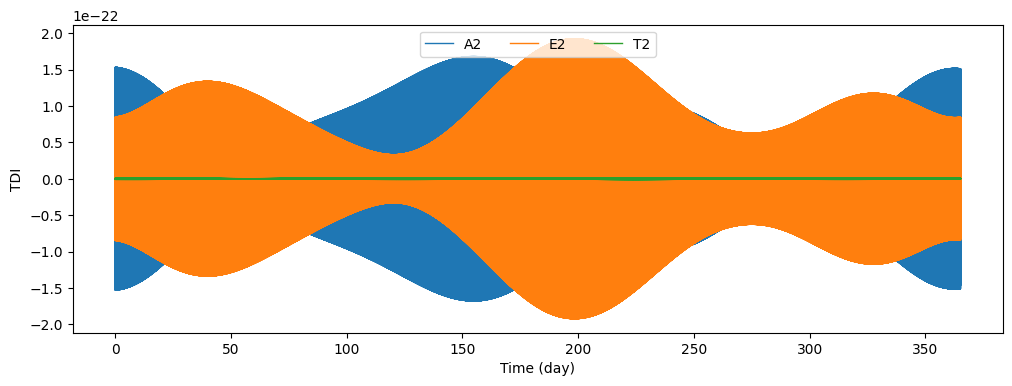

In [75]:
plt.figure(figsize=(12,4))
for i in range(len(gb_response_td)):
    plt.plot(tcb_times/DAY, gb_response_td[i], linewidth=1, label=channel_names[i])
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper center", ncols=len(gb_response_td))

In [76]:
gb_response_fd = [] 
for i in range(len(gb_response_td)):
    ff, xf = FFT_window(
        gb_response_td[i], 
        fsample=1./dt, 
        window_type="tukey", 
        window_args_dict=dict(alpha=10000/Tobs), 
    )
    gb_response_fd.append(xf)
gb_response_fd = np.array(gb_response_fd)
full_frequency = ff.copy() 

# slice data into a small band around the target frequency 
band_width = 1e-5 
band_idx = np.where(np.abs(full_frequency-gb_parameters["f0"])<band_width)[0]
band_frequency = full_frequency[band_idx]
gb_response_fd_band = gb_response_fd[:, band_idx]

gb_response_fd_band.shape 

(3, 631)

## Generate frequency domain template 

In [77]:
xyz = gb_response_generator_tdifly(
    parameters=gb_parameters, 
    domain="frequency", 
)
aet = gb_response_generator_tdifly.XYZtoAET(xyz)
gb_response_fd_band_tdifly = gb_response_generator_tdifly.fill_fftseries(
    data=aet, 
    start_idx=gb_response_generator_tdifly.start_idx, 
    StartBound=band_idx[0]+1, 
    EndBound=band_idx[-1]+1,
)[:, 0]

gb_response_fd_band_tdifly.shape 

(3, 631)

## Compare 

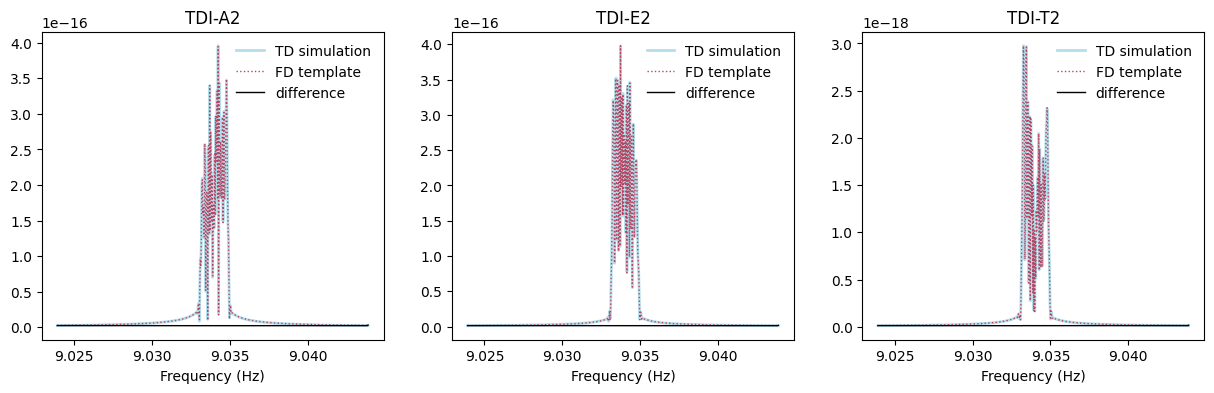

In [78]:
plt.figure(figsize=(15, 4))
for i in range(len(gb_response_fd_band_tdifly)): 
    plt.subplot(131+i)
    plt.plot(band_frequency*1e3, np.abs(gb_response_fd_band[i]), color=BLUE, linewidth=2, alpha=0.5, label="TD simulation")
    plt.plot(band_frequency*1e3, np.abs(gb_response_fd_band_tdifly[i]), linewidth=1, linestyle=":", color=RED, label="FD template")
    plt.plot(band_frequency*1e3, np.abs(gb_response_fd_band_tdifly[i]-gb_response_fd_band[i]), linewidth=1, color="k", label="difference")
    plt.xlabel("Frequency (Hz)")
    plt.title("TDI-"+channel_names[i])
    plt.legend(loc="upper right", frameon=False)

In [79]:
gb_response_generator_tdifly.mismatch(h1=gb_response_fd_band, h2=gb_response_fd_band_tdifly[:, np.newaxis, :])

array([0.00036493])